## Challenge 1: Titanic - Train after FE

### Import thư viện và đọc dữ liệu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Đọc dữ liệu sau Feature Engineering
train = pd.read_excel("../exps/data/train_feat.xlsx")
test = pd.read_excel("../exps/data/test_feat.xlsx")

print("Đọc dữ liệu thành công:", train.shape, test.shape)
train.head()

Đọc dữ liệu thành công: (891, 20) (418, 19)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,Deck,Title,FamilySize,FamilyType,IsAlone,AgeBin,FareBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,0,U,Mr,2,Small,0,YoungAdult,Low
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,C,Mrs,2,Small,0,Adult,VeryHigh
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,0,U,Miss,1,Single,1,YoungAdult,Mid
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,C,Mrs,2,Small,0,Adult,VeryHigh
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,0,U,Mr,1,Single,1,Adult,Mid


### Xử lý dữ liệu trước khi train

In [3]:
# Loại bỏ cột không cần thiết
drop_cols = ["PassengerId", "Name", "Ticket", "Cabin"]
for col in drop_cols:
    if col in train.columns:
        train.drop(columns=col, inplace=True, errors="ignore")
        test.drop(columns=col, inplace=True, errors="ignore")

# Xử lý các cột phân loại (Label Encoding)
cat_cols = train.select_dtypes(include="object").columns
le = LabelEncoder()
for col in cat_cols:
    all_vals = pd.concat([train[col], test[col]], axis=0)
    le.fit(all_vals)
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])

# Chuẩn hóa dữ liệu (scale)
scale_cols = ["Age", "Fare", "FamilySize"]
scaler = StandardScaler()
train[scale_cols] = scaler.fit_transform(train[scale_cols])
test[scale_cols] = scaler.transform(test[scale_cols])

print("Hoàn tất xử lý dữ liệu trước train")
train.head()

Hoàn tất xử lý dữ liệu trước train


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin,Deck,Title,FamilySize,FamilyType,IsAlone,AgeBin,FareBin
0,0,3,1,-0.565736,1,0,-0.502445,2,0,8,2,0.059160,2,0,4,1
1,1,1,0,0.663861,1,0,0.786845,0,1,2,3,0.059160,2,0,0,3
2,1,3,0,-0.258337,0,0,-0.488854,2,0,8,1,-0.560975,1,1,4,2
3,1,1,0,0.433312,1,0,0.420730,2,1,2,3,0.059160,2,0,0,3
4,0,3,1,0.433312,0,0,-0.486337,2,0,8,2,-0.560975,1,1,0,2


### Tách dữ liệu train/test nội bộ

In [4]:
X = train.drop("Survived", axis=1)
y = train["Survived"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train:", X_train.shape, "| X_val:", X_val.shape)

X_train: (712, 15) | X_val: (179, 15)


### Train & đánh giá nhiều mô hình

In [6]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    results.append([name, acc, prec, rec, f1])

df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
df_results = df_results.sort_values(by="F1", ascending=False).reset_index(drop=True)
df_results

,Model,Accuracy,Precision,Recall,F1
0,XGBoost,0.821229,0.776119,0.753623,0.764706
1,SVM,0.804469,0.729730,0.782609,0.755245
2,Random Forest,0.810056,0.761194,0.739130,0.750000
3,Logistic Regression,0.810056,0.769231,0.724638,0.746269
4,Gradient Boosting,0.793296,0.775862,0.652174,0.708661
5,Decision Tree,0.754190,0.692308,0.652174,0.671642


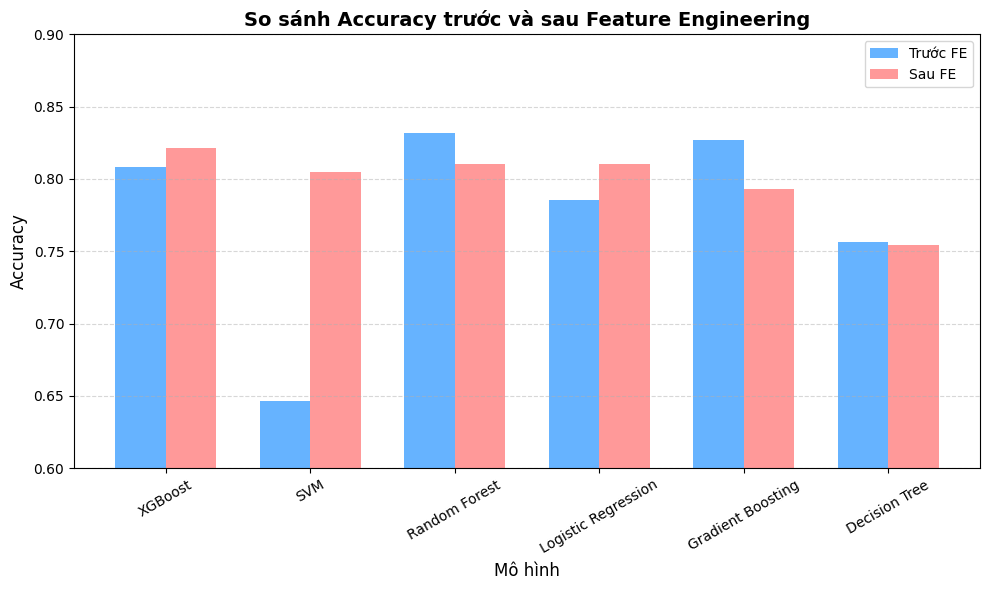

In [7]:
# So sánh Accuracy trước và sau Feature Engineering

import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu Accuracy
models = ["XGBoost", "SVM", "Random Forest", "Logistic Regression", "Gradient Boosting", "Decision Tree"]
acc_before = [0.808077, 0.646442, 0.831610, 0.785618, 0.827166, 0.756492]
acc_after  = [0.821229, 0.804469, 0.810056, 0.810056, 0.793296, 0.754190]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, acc_before, width, label="Trước FE", color="#66b3ff")
plt.bar(x + width/2, acc_after, width, label="Sau FE", color="#ff9999")

plt.xlabel("Mô hình", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("So sánh Accuracy trước và sau Feature Engineering", fontsize=14, fontweight="bold")
plt.xticks(x, models, rotation=30)
plt.ylim(0.6, 0.9)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

**Nhận xét**

Sau khi thêm các đặc trưng mới như Title, FamilySize, IsAlone, và các biến tương tác khác, kết quả cho thấy:
 
- Một số mô hình cải thiện rõ rệt về độ chính xác (Accuracy) và cân bằng giữa Precision/Recall.

- SVM tăng mạnh nhất (+0.16 Accuracy), từ 0.64 → 0.80 — do mô hình này nhạy với đặc trưng phi tuyến nên hưởng lợi từ các đặc trưng mới có tính phân biệt cao.

- Logistic Regression và XGBoost cũng cải thiện nhẹ, chứng tỏ các đặc trưng mới giúp mô hình tuyến tính nhận diện tốt hơn giữa nhóm sống và không sống.

- Random Forest và Gradient Boosting hơi giảm nhẹ (khoảng -0.02 đến -0.03).
→ Có thể do các mô hình này đã tự động khai thác quan hệ phi tuyến giữa biến gốc, nên việc thêm đặc trưng mới không tạo ra khác biệt lớn, thậm chí gây dư thừa nhẹ.

**Tổng quan:**

- Feature Engineering tăng độ ổn định giữa các mô hình.

- Kết quả cao nhất đạt 0.82 Accuracy (XGBoost) sau FE — cho thấy tiềm năng khi kết hợp FE + tinh chỉnh tham số (hyperparameter tuning).